In [1]:
hist_fit_file = "./history_fitness.csv"
hist_pop_file = "./history_pop.csv"

In [2]:
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
import numpy as np

In [3]:
df_fit = pd.read_csv(hist_fit_file)
df_fit.head()

,generation,id,fitness,species,parent1,parent2
0,0,75,1.577541,1,-1,-1
1,1,75,1.577541,5,-1,-1
2,2,275,2.139220,1,161,75
3,3,328,2.425107,1,75,262
4,4,328,2.425107,9,75,262


In [4]:
df_pop = pd.read_csv(hist_pop_file)
df_pop.head()

,generation,id,fitness,species,parent1,parent2
0,0,1,0.144707,1,-1,-1
1,0,2,0.013128,1,-1,-1
2,0,3,0.046842,1,-1,-1
3,0,4,0.065537,1,-1,-1
4,0,5,-0.053513,1,-1,-1


In [5]:
global_best_hist = df_fit["fitness"].values
avg_hist = df_pop.groupby("generation").mean()["fitness"].values
std = df_pop.groupby("generation").std()["fitness"].values

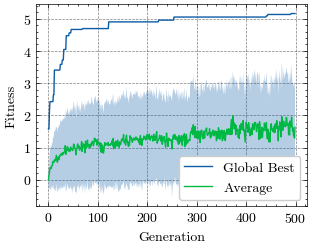

In [6]:
plt.style.use(['science', 'grid', 'no-latex'])

fig, ax = plt.subplots()
ax.plot(global_best_hist, label="Global Best")
ax.plot(avg_hist, label="Average")
ax.fill_between(range(len(avg_hist)), avg_hist-std, avg_hist+std, alpha=0.3)
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

plt.legend()
plt.show()

In [7]:
max_gen = df_pop["generation"].max() # 終了世代
species_data = {}
for key in df_pop["species"].unique():
    current_species = df_pop[df_pop["species"] == key] # 現在の種の行のみを取得

    ### 種の生存期間
    created = current_species["generation"].min()     # 種の生成世代
    extinct = current_species["generation"].max() + 1 # 種の絶滅世代（計算上，種が消されるのは次の世代）

    ### 祖先の種の取得
    first_genome_parent = current_species['parent1'].iloc[0] # 種に属する最初の個体の親から派生元の種を特定
    if first_genome_parent==-1:
            # 初期個体の場合は祖先なし
            ancestor = -1
    else:
        # 祖先の種を特定
        ancestor = df_pop['species'].iloc[(df_pop['id']==first_genome_parent).idxmax()] # 種に属する最初の個体の親idが最後に所属した種id

    ### 種の適応度の推移
    fitness_hist_average = np.array(current_species.groupby("generation").mean()["fitness"].values)
    fitness_hist_std = np.array(current_species.groupby("generation").std()["fitness"].values)

    fitness_hist_average_zeros = np.zeros(max_gen+1)
    fitness_hist_average_zeros[created:extinct] = fitness_hist_average
    fitness_hist_std_zeros = np.zeros(max_gen+1)
    fitness_hist_std_zeros[created:extinct] = fitness_hist_std

    fitness_hist_average = fitness_hist_average_zeros
    fitness_hist_std = fitness_hist_std_zeros

    species_data[key] = {
        "created": created,
        "extinct": extinct,
        "ancestor": ancestor,
        "fitness_hist_average": fitness_hist_average,
        "fitness_hist_std": fitness_hist_std
    }

In [8]:
 ### 種の描画順序を決定
order = []
stack = [-1] # 祖先なしの種にはancestor=-1が設定されているため，-1を初期値としてstackに追加
while len(stack)>0:
    k = stack.pop(0)
    for key,species in species_data.items():
        if species['ancestor']==k:
            stack.insert(0, key) # stackの先頭にkeyを挿入
    order.append(k) # stackから取り出したkeyをorderに追加
order = order[1:]  # 最初の-1を削除

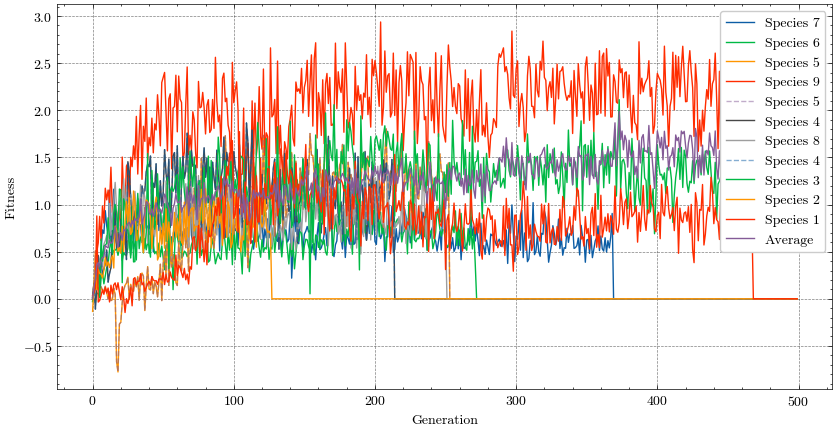

In [9]:
# 種の適応度の推移を描画
fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use(['science', 'grid', 'no-latex'])
for key in order:
    species = species_data[key]
    ax.plot(species["fitness_hist_average"], label=f"Species {key}") # 種の適応度の平均の推移を描画
    # ax.fill_between(range(len(species["fitness_hist_average"])), species["fitness_hist_average"]-species["fitness_hist_std"], species["fitness_hist_average"]+species["fitness_hist_std"], alpha=0.3) # 種の適応度の標準偏差の範囲を描画

    if species["ancestor"] != -1:
        ancestor = species_data[species["ancestor"]]
        ax.plot(ancestor["fitness_hist_average"], label=f"Species {species['ancestor']}", linestyle="--", alpha=0.5)

# 全体の適応度(avg_hist)の推移を描画
ax.plot(avg_hist, label="Average")

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
plt.legend()
plt.savefig("result_trends")
plt.show()